In [1]:
!pip install torch

In [36]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp39-cp39-win_amd64.whl (4.1 MB)


In [9]:
!pip install matplotlib

### Import Necessary Packages.

In [1]:
"""
All necessary imports needed to run the notebook.
"""
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from PIL import Image
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

### Set device to use GPU if avaliable.

In [2]:
"""
Check pytorch version and device is correct.
"""
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Count:", torch.cuda.device_count())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

PyTorch Version: 2.5.1+cu121
CUDA Available: True
CUDA Version: 12.1
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 3060


In [3]:
"""
Set device to cuda(GPU) if avaliable.
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
"""
Transformations the images go through before they are brought into the notebook. (Preprocessing) 
"""
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Adjust the crop size
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [19]:
"""
Load in the training and validation data and apply the transformations.
"""
train_dataset = datasets.ImageFolder(root="./Dataset/Disasters/train", transform=transform)
val_dataset = datasets.ImageFolder(root="./Dataset/Disasters/validation", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [21]:
"""
Define images and their labels and print size.
"""
images, labels = next(iter(train_loader))
print(images.shape)  # Should be [batch_size, 3, 224, 224]

torch.Size([32, 3, 224, 224])


In [22]:
"""
Ensure the classes are as expected.
"""
print("Classes:", train_dataset.classes)

Classes: ['cyclone', 'earthquake', 'flood', 'wildfire']


In [23]:
"""
Load in the pre trained ResNet-50 and ensure it is running on GPU.
"""
model = models.resnet18(pretrained=True)

# Modify the final layer to match 4 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model, device)  # Check the modified model structure

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\corey\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
"""
Set learning rate and use cross entropy loss.
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can also try SGD

In [25]:
"""
Train the model run the epochs and compute loss and accuracy.
"""
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch [1/10], Loss: 0.4277
Epoch [2/10], Loss: 0.2293
Epoch [3/10], Loss: 0.1759
Epoch [4/10], Loss: 0.1040
Epoch [5/10], Loss: 0.1183
Epoch [6/10], Loss: 0.1035
Epoch [7/10], Loss: 0.0836
Epoch [8/10], Loss: 0.0988
Epoch [9/10], Loss: 0.1082
Epoch [10/10], Loss: 0.0538
Training complete!


In [26]:
"""
Evaluate the model with the validation data 
"""
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Convert tensors to numpy
        all_predictions.extend(predicted.cpu().numpy())

# Compute Precision, Recall, and F1-score
precision = precision_score(all_labels, all_predictions, average='weighted')  # Change to 'macro' if needed
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print results
print(f"Validation Accuracy: {100 * (sum(1 for x, y in zip(all_labels, all_predictions) if x == y) / len(all_labels)):.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(all_labels, all_predictions, target_names=train_dataset.classes))

Validation Accuracy: 94.25%
Precision: 0.9482
Recall: 0.9425
F1 Score: 0.9431

Classification Report:
               precision    recall  f1-score   support

     cyclone       0.96      0.95      0.95       100
  earthquake       0.85      1.00      0.92       100
       flood       0.98      0.91      0.94       100
    wildfire       1.00      0.91      0.95       100

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.94       400
weighted avg       0.95      0.94      0.94       400



In [38]:
def predict_image(image_path, model, class_names):
    """
    Takes in an image and makes a prediction on the image class.
    """
    model.eval()
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Preprocess and add batch dimension
    
    with torch.no_grad():
        output = model(image)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    print(f"Predicted Class: {class_names[predicted_class]}, Confidence: {probabilities[0][predicted_class]:.2f}")

"""
Test run of the predictor (function call)
"""
for i in range(500, 600):
    print(predict_image(f"./Dataset/Disasters/test/earthquake/{i}.jpg", model, train_dataset.classes), i)


Predicted Class: earthquake, Confidence: 1.00
None 500
Predicted Class: earthquake, Confidence: 1.00
None 501
Predicted Class: earthquake, Confidence: 1.00
None 502
Predicted Class: earthquake, Confidence: 1.00
None 503
Predicted Class: earthquake, Confidence: 1.00
None 504
Predicted Class: earthquake, Confidence: 1.00
None 505
Predicted Class: earthquake, Confidence: 1.00
None 506
Predicted Class: earthquake, Confidence: 1.00
None 507
Predicted Class: earthquake, Confidence: 1.00
None 508
Predicted Class: earthquake, Confidence: 1.00
None 509
Predicted Class: earthquake, Confidence: 0.96
None 510
Predicted Class: earthquake, Confidence: 1.00
None 511
Predicted Class: earthquake, Confidence: 1.00
None 512
Predicted Class: earthquake, Confidence: 1.00
None 513
Predicted Class: earthquake, Confidence: 1.00
None 514
Predicted Class: earthquake, Confidence: 1.00
None 515
Predicted Class: earthquake, Confidence: 1.00
None 516
Predicted Class: earthquake, Confidence: 1.00
None 517
Predicted 

In [37]:
print(predict_image(f"./Dataset/test_wildfire.jpg", model, train_dataset.classes))

Predicted Class: wildfire, Confidence: 1.00
None


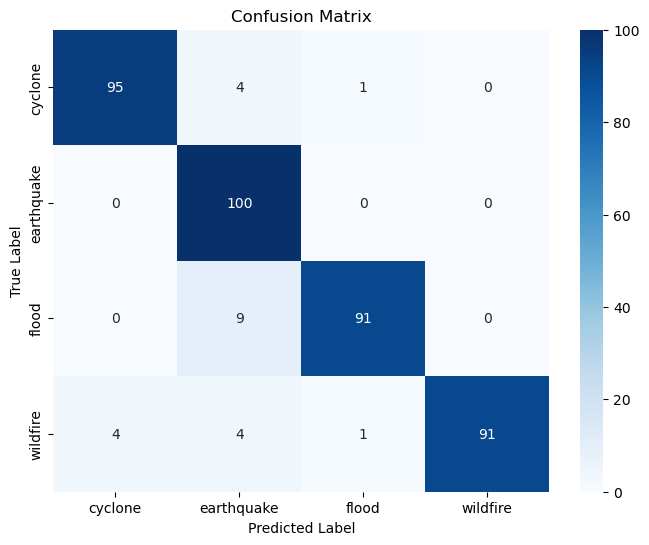

In [42]:
"""
Compute confusion matrix to show where mistakes happened during validation.
"""
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


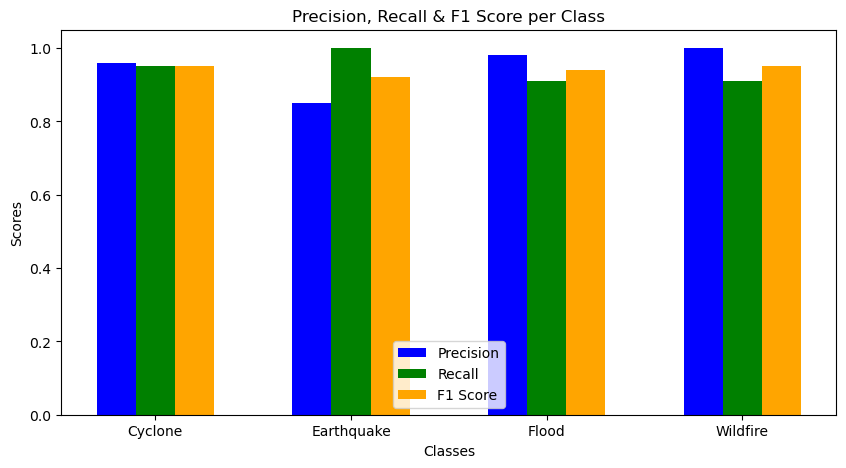

In [45]:
"""
Compute a bar chart to show the evaluation metrics for each class.
"""
class_labels = ['Cyclone', 'Earthquake', 'Flood', 'Wildfire']

# Precision, Recall, F1 scores (from classification report)
precision = [0.96, 0.85, 0.98, 1.00]
recall = [0.95, 1.00, 0.91, 0.91]
f1_score = [0.95, 0.92, 0.94, 0.95]

x = np.arange(len(class_labels))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 5))

# Create bars for precision, recall, and F1-score
ax.bar(x - width, precision, width, label='Precision', color='blue')
ax.bar(x, recall, width, label='Recall', color='green')
ax.bar(x + width, f1_score, width, label='F1 Score', color='orange')

# Labels & Title
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall & F1 Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend()

plt.show()